## United States Elections Glossary
#### By Davis Westover, Dinesh Rustagi, Arman Keshavarz, and Ryan Chiang

- [Introduction](#intro): Overview of the United States Elections section.
- [Data Selection](#data): Explanation of the data selection process for United States Elections analysis.
- [Ethnicity Graphs](#ethnic): Discussion and visualization of ethnic demographics in United States Elections.
- [Firearm Code](#gundata): Description of the firearm data used in the analysis.
- [Firearm by Party Visualization](#partyfire): Visualization of firearm ownership statistics by political party affiliation.
- [Firearm by Ethnicity](#ethnicfire): Ethnicity and Firearm Ownership. 
- [Data Curation and Time Series](#timeseries): Time Series on Voting by Ethnicity over time. 
- [Alignment and Ethnicity Data](#align): Ethnicity and Political Alignment Information.
- [Alignment and Ethnicity Visualization](#aligntable): Visualization of Ethnic Alignment.
- [Machine Learning](#ml): Predictive Machine Learning Algorithm.
- [Conclusion](#con): Results and Takeaways.

In [1]:
from IPython.display import Image, display
from pyspark.sql.functions import when
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
image_url = "https://media.cnn.com/api/v1/images/stellar/prod/170911135115-0911-2016-election-results-map.jpg?q=x_2,y_0,h_898,w_1596,c_crop/w_800"
# Display the image
display(Image(url=image_url))

<a id="intro"></a>
##                                                           Relation between Voting, Firearm Ownership, and Race

    United States politics are often considered to be extremely divided. Issues stemming from racial division, firearms ownership, and geographical location can dictate often how individuals will align themselves politically. With the system of the States being a republic and not a direct democracy, people will often vote in waves and utilize representatives to speak in their stead. In this project, we will dive into the extraneous factors dictating voting and decisions in Atlanta and New York to determine such. Utilizing information from Google Cloud and Jupyter as our interface, we propose the question; is there a correlation between firearm ownership and race in voter participation?
  
    Immediate steps in determining our proposed question began with the manipulation of the provided parquet files in the Google Cloud bucket. In this public resource, our group utilized shell to begin loading the data and through this process, selected the cities of New York and Atlanta as our exploration topics. Loading this information into Big Query and likewise Jupyter, information was combed for interesting subjects that could influence voting decisions. The overview of information proved unique. Queries relating to Georgia displayed that there was a disproportionate amount of individuals who voted and owned firearms. This revelation further reinforced that the topic held merit. Later queries displayed the firearm demographics of voting alignment along with their general decisions. Tailing from this further queries went into more personal topics such as if firearm owners voted based on party which displayed a mixed bag of results. Ratios that were generally recorded were that of firearms owners 90.64% voted which appears rather high for any voting population demographic. A deeper dive into individual cities was necessary to explore this discovery.
   
    With this combined information, the project began with further dividing the topics and influencing factors into a comprehensive report. In this summary we will explore the plausibility on voter turn out with influence on their ethnity along with a time series displaying changes in behavior or citizens.

<a id="data"></a>
## Data Selection

In [2]:
from pyspark.sql.functions import when
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
spark = SparkSession \
.builder \
.appName("Read Voter File Data") \
.getOrCreate()
df = (
spark.read
.format("parquet")
.option("header", "true")
.option("inferSchema", "true")
.load("gs://georgia_data_1738/clean_dataset.parquet")
)

df.createOrReplaceTempView("df")

In [4]:
df.columns
df = df.select(
    'EthnicGroups_EthnicGroup1Desc',
    'Residence_Addresses_City',
    'Residence_Addresses_Property_HomeSq_Footage',
    'Voters_Gender',
    'Voters_Age',
    'Parties_Description',
    'MaritalStatus_Description',
    'MilitaryStatus_Description',
    'Weed_District',
    'CommercialDataLL_HH_Net_Worth',
    'CommercialDataLL_Business_Owner',
    'CommercialDataLL_Gun_Owner',
    'CommercialDataLL_Gun_Owner_Concealed_Permit',
    'General_2000',
    'General_2002',
    'General_2004',
    'General_2006',
    'General_2008',
    'General_2010',
    'General_2012',
    'General_2014',
    'General_2016',
    'General_2018',
    'General_2020',
    'General_2022'
)


In [5]:
df = df.withColumn("EthnicGroups_EthnicGroup1Desc",
                                        when(df["EthnicGroups_EthnicGroup1Desc"] == "Likely African-American",
                                             "African-American")
                                       .when(df["EthnicGroups_EthnicGroup1Desc"] == "Hispanic and Portuguese",
                                             "Hispanic")
                                        .otherwise(df["EthnicGroups_EthnicGroup1Desc"]))

In [6]:
df = df.withColumn("Parties_Description",
                   when(df["Parties_Description"].isin(["Independence", "Green", "Libertarian", "Reform", "Women's Equality Party", "Working Family Party"]),
                        "Other")
                   .when(df["Parties_Description"]== 'Conservative',
                        "Republican")
                   .otherwise(df["Parties_Description"]))

In [7]:
df_atl = df.filter((df["Residence_Addresses_City"] == "Atlanta"))
df_atl.createOrReplaceTempView("df_atl")
df_nyc = df.filter((df["Residence_Addresses_City"] == "New York"))
df_nyc.createOrReplaceTempView("df_nyc")

In [8]:
df_nyc.columns
df_atl.columns

['EthnicGroups_EthnicGroup1Desc',
 'Residence_Addresses_City',
 'Residence_Addresses_Property_HomeSq_Footage',
 'Voters_Gender',
 'Voters_Age',
 'Parties_Description',
 'MaritalStatus_Description',
 'MilitaryStatus_Description',
 'Weed_District',
 'CommercialDataLL_HH_Net_Worth',
 'CommercialDataLL_Business_Owner',
 'CommercialDataLL_Gun_Owner',
 'CommercialDataLL_Gun_Owner_Concealed_Permit',
 'General_2000',
 'General_2002',
 'General_2004',
 'General_2006',
 'General_2008',
 'General_2010',
 'General_2012',
 'General_2014',
 'General_2016',
 'General_2018',
 'General_2020',
 'General_2022']

    
    Starting by our information selection along with the attributes examined, the project outlines data through several extraneous factors and elements to help dictate the direction we decide to head from. In the above section, our data is loaded and prepared for further manipulation through Spark SQL service to help partition and comb the data into our later linear regression models, graphs, and overarching analysis.

In [9]:
nyc_race = spark.sql("""
    SELECT EthnicGroups_EthnicGroup1Desc as Ethnicity
    FROM df_nyc
"""
)
nyc_race = nyc_race.filter(nyc_race['Ethnicity'].isNotNull())
nyc_race.createOrReplaceTempView("nyc_race")
nyc_race = spark.sql("""
    SELECT Ethnicity, COUNT(*) / (SELECT COUNT(*) FROM nyc_race) * 100 AS Percentage
    FROM nyc_race
    GROUP BY Ethnicity
    ORDER BY percentage DESC
"""
)
# Show the result
nyc_race = nyc_race.toPandas().sort_values(by='Ethnicity')

In [10]:
atl_race = spark.sql("""
    SELECT EthnicGroups_EthnicGroup1Desc as Ethnicity
    FROM df_atl
"""
)
atl_race = atl_race.filter(atl_race['Ethnicity'].isNotNull())
atl_race.createOrReplaceTempView("atl_race")
atl_race = spark.sql("""
    SELECT Ethnicity, COUNT(*) / (SELECT COUNT(*) FROM atl_race) * 100 AS Percentage
    FROM atl_race
    GROUP BY Ethnicity
    ORDER BY percentage DESC
"""
)

# Show the result
atl_race = atl_race.toPandas().sort_values(by='Ethnicity')

    Beginning with this subject of ethnicity, we decided to visualize our ethnic makeup without extreneous factors to get an idea of base demographics. Declaring the racial makeup of NYC to observe in various graphs, NYC race was queried to show the percentage of ethnic makeup of the city. It appears that although being diverse in population, New York City still remains Caucasian/European dominant. This was then done by Atlanta as well to a result that displayed African Americans in the City of Atlanta to be the prodominant ethnicity in the City. This was then followed by European/Caucasians.

    Comparing New York and Atlanta, Both have a high Caucasian population. They differ in that Atlanta has a much higher African-American Population rate, while New York has higher rates of Hispanic and Asian Ethnicities. These correlations will be later explored in the exploratory analysis section along with visualizations.

<a id="ethnic"></a>

## Ethnic Visualization
    In this section we observe the prodominate ethnic makeup of each city we are observing.

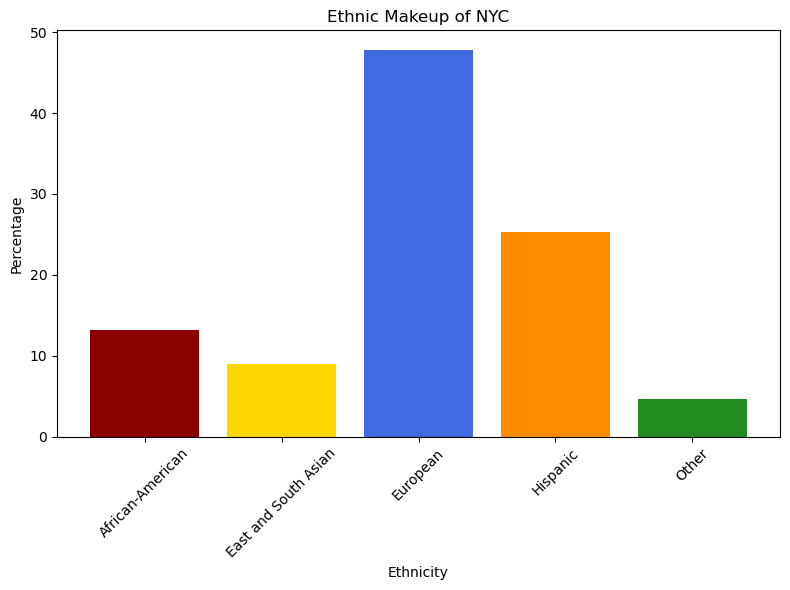

In [11]:
plt.figure(figsize=(8, 6))
plt.bar(nyc_race['Ethnicity'], nyc_race['Percentage'], color=['darkred','gold','royalblue','darkorange','forestgreen'])
plt.xlabel('Ethnicity')
plt.ylabel('Percentage')
plt.title('Ethnic Makeup of NYC')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

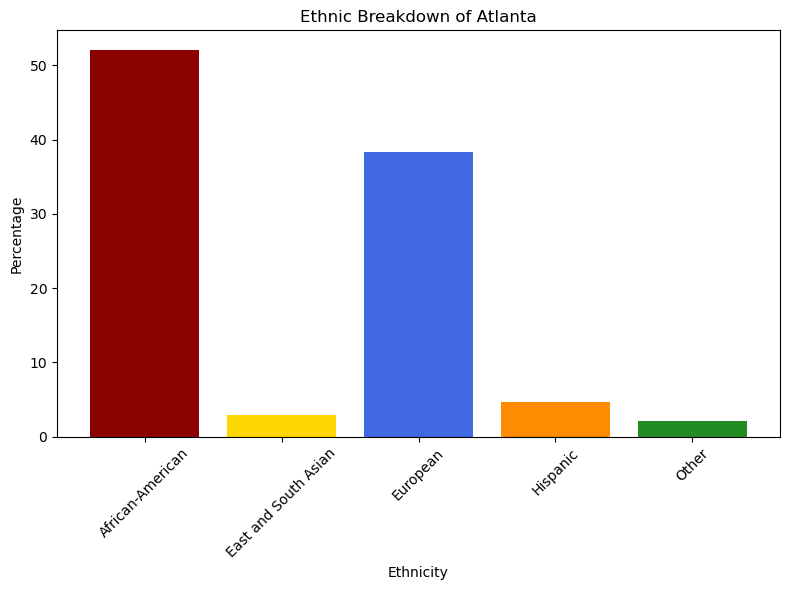

In [12]:
plt.figure(figsize=(8, 6))
plt.bar(atl_race['Ethnicity'], atl_race['Percentage'], color=['darkred','gold','royalblue','darkorange','forestgreen'])
plt.xlabel('Ethnicity')
plt.ylabel('Percentage')
plt.title('Ethnic Breakdown of Atlanta')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

    Utilitizing histograms, we are easily able to assertain the ethnic demographic and begin on the secondary observation, firearm ownership which is then examined by ethnicity to assist in moving towards our research question along with our later algorithm. Below, Ethnicity is grouped in order by the 2020 election year and a simple yes or no query if said ethnic demographic owned a firearm. A percentage is then returned to help in determining the significance of owning a firearm and voter participation.

<a id="gundata"></a>
## Firearm Data and Visualization
    In spark NYC and ATL is queried to begin narrowing down the information to political aligance and ownership which can assist us in better visualizing and understanding interactions between our data elements and topic. This is done through spark and later uploaded to Pandas for ease of use. 

In [13]:
nyc_gunrace = spark.sql("""
    SELECT EthnicGroups_EthnicGroup1Desc as Ethnicity, General_2020, COALESCE(CommercialDataLL_Gun_Owner, 'No') AS Gun_Owner
    FROM df_nyc
"""
)
nyc_gunrace = nyc_gunrace.filter(nyc_gunrace['Ethnicity'].isNotNull())
nyc_gunrace.createOrReplaceTempView("nyc_gunrace")
nyc_gunrace = spark.sql("""
    SELECT Ethnicity, Gun_Owner,
    COUNT(General_2020) * 100 / COUNT(*) AS Percentage_Voted
    FROM nyc_gunrace
    GROUP BY Ethnicity, Gun_Owner
    ORDER BY Percentage_Voted DESC
"""
)
# Show the result
nyc_gunrace = nyc_gunrace.toPandas().sort_values(by='Ethnicity')
nyc_gunrace.head()

atl_gunrace = spark.sql("""
    SELECT EthnicGroups_EthnicGroup1Desc as Ethnicity, General_2020, COALESCE(CommercialDataLL_Gun_Owner, 'No') AS Gun_Owner
    FROM df_atl
"""
)
atl_gunrace = atl_gunrace.filter(atl_gunrace['Ethnicity'].isNotNull())
atl_gunrace.createOrReplaceTempView("atl_gunrace")
atl_gunrace = spark.sql("""
    SELECT Ethnicity, Gun_Owner,
    COUNT(General_2020) * 100 / COUNT(*) AS Percentage_Voted
    FROM atl_gunrace
    GROUP BY Ethnicity, Gun_Owner
    ORDER BY Percentage_Voted DESC
"""
)
# Show the result
atl_gunrace = atl_gunrace.toPandas().sort_values(by='Ethnicity')

    It appears that throughout both cities, citizens on all averages are more likely to participate politically if they own a firearm, this indicates that our direction and question proved merit and can be further examined and likely modeled.

<a id="fireparty"></a>
## Firearm Political Alignment and Visualization
    In this instance, we are observing the correlation between firearm ownership and individual political alignment in both cities. The suprising factor related to each is that Democrats in both cities appear to be dominant in gun ownership versus the previously assumed Republican party. This could be primarily due to the dominant population being Democrat however a point to note is the disproportionate firearm ownership displayed in Atlanta by Republicans on gun owner percentage with only 11.14% of the population owning 36.18% of all firearms. This is explored in the later topics. The below graphs set next to each other first each political party's representation in the general population, then each party's representation among the gun owning population.

In [14]:
atl_partygun = spark.sql("""
    SELECT Parties_Description as Party, COALESCE(CommercialDataLL_Gun_Owner, 'No') AS Gun_Owner
    FROM df_atl
"""
)
atl_partygun = atl_partygun.filter(atl_partygun['Party'].isNotNull())
atl_partygun.createOrReplaceTempView("atl_partygun")
atl_partygun = spark.sql("""
SELECT
    Party,
    COUNT(*) * 100.0 / (SELECT COUNT(*) FROM atl_partygun) AS Population_Percentage,
    SUM(CASE WHEN Gun_owner = 'Yes' THEN 1 ELSE 0 END) * 100.0 / NULLIF((SELECT COUNT(*) FROM atl_partygun WHERE Gun_owner = 'Yes'), 0) AS Gun_Owner_Percentage
FROM
    atl_partygun
GROUP BY
    Party
"""
)
# Show the result
atl_partygun = atl_partygun.toPandas().sort_values(by='Party')

In [15]:
nyc_partygun = spark.sql("""
    SELECT Parties_Description as Party, COALESCE(CommercialDataLL_Gun_Owner, 'No') AS Gun_Owner
    FROM df_nyc
"""
)
nyc_partygun = nyc_partygun.filter(nyc_partygun['Party'].isNotNull())
nyc_partygun.createOrReplaceTempView("nyc_partygun")
nyc_partygun = spark.sql("""
SELECT
    Party,
    COUNT(*) * 100.0 / (SELECT COUNT(*) FROM nyc_partygun) AS Population_Percentage,
    SUM(CASE WHEN Gun_owner = 'Yes' THEN 1 ELSE 0 END) * 100.0 / NULLIF((SELECT COUNT(*) FROM nyc_partygun WHERE Gun_owner = 'Yes'), 0) AS Gun_Owner_Percentage
FROM
    nyc_partygun
GROUP BY
    Party
"""
)
# Show the result
nyc_partygun = nyc_partygun.toPandas().sort_values(by='Party')

    Quick examination displays the percentages of New York City and Atlanta along with their respective political population alignment. Both appear to be prodominately Democratic as cities tend to be 'blue' hubs. In New York, gun owner representation closely aligns with demographic rates. However, in Atlanta, despite making up only 11.15% of the population, Republicans make up nearly 36.2% of firearm owners. 

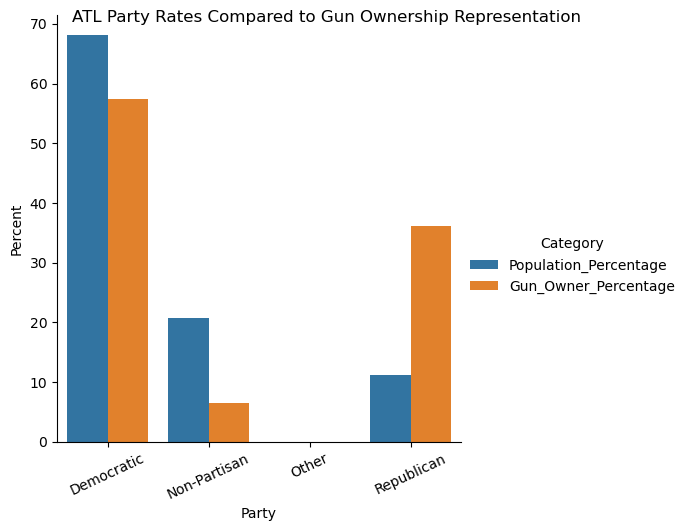

In [16]:
atl_melt2 = pd.melt(atl_partygun, id_vars=['Party'], value_vars=['Population_Percentage', 'Gun_Owner_Percentage'], var_name='Category', value_name='Percent')
i = sns.catplot(kind='bar', data = atl_melt2, x = 'Party', y = 'Percent', hue = 'Category')
i.fig.suptitle('ATL Party Rates Compared to Gun Ownership Representation')
plt.xticks(rotation=25)
plt.show()

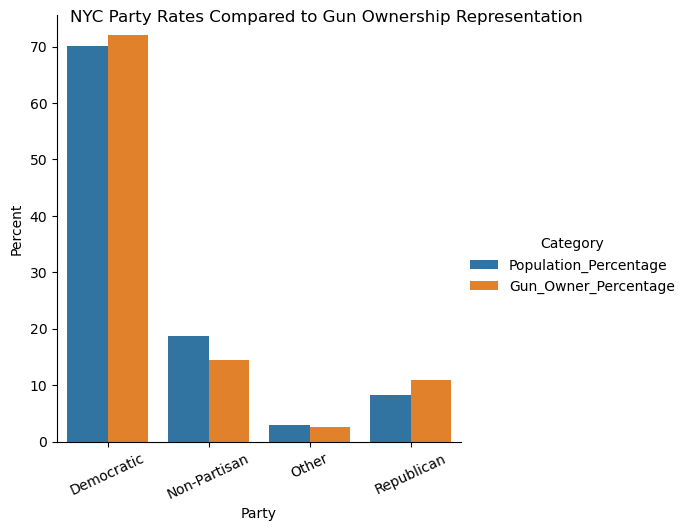

In [17]:
nyc_melt2 = pd.melt(nyc_partygun, id_vars=['Party'], value_vars=['Population_Percentage', 'Gun_Owner_Percentage'], var_name='Category', value_name='Percent')
h = sns.catplot(kind='bar', data = nyc_melt2, x = 'Party', y = 'Percent', hue = 'Category')
h.fig.suptitle('NYC Party Rates Compared to Gun Ownership Representation')
plt.xticks(rotation=25)
plt.show()

<a id="ethnicfire"></a>
## Ethnicity Versus Firearm Ownership
    In this section we explore the ratios between firearm ownership and ethnicity in the cities of New York and Atlanta. The following information appeared suprising as in all catagories in both cities, firearm owners voted more often and participated much more regardless of ethnic background. This data allows us to proceed onto the next phase of this project explorative topic. 

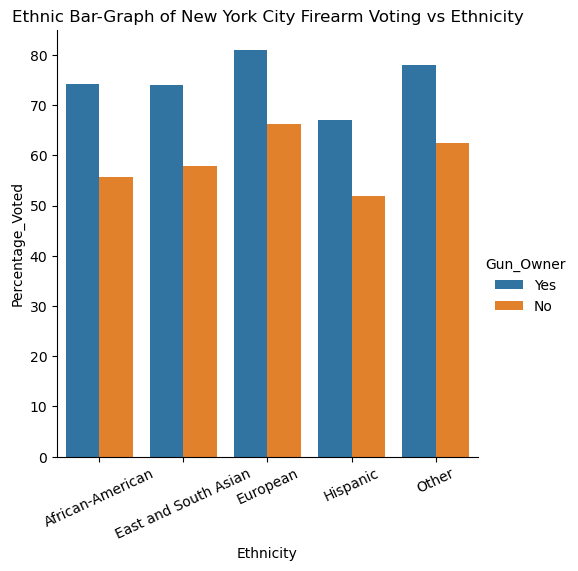

In [18]:
sns.catplot(kind='bar', data = nyc_gunrace, x = 'Ethnicity', y = 'Percentage_Voted', hue = 'Gun_Owner')
plt.xticks(rotation=25)
plt.title("Ethnic Bar-Graph of New York City Firearm Voting vs Ethnicity")
plt.show()

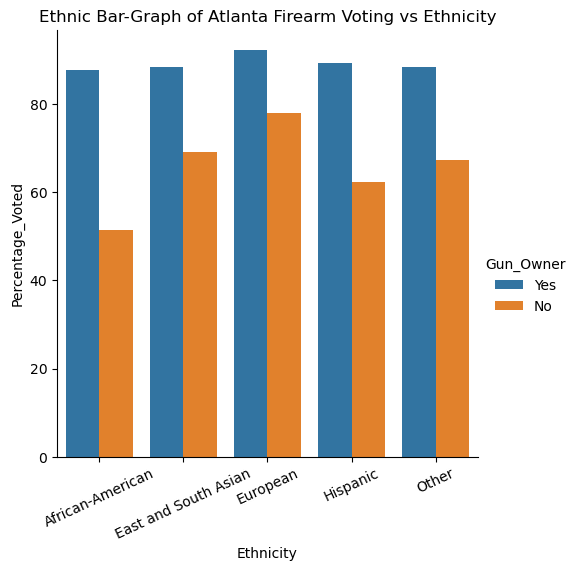

In [19]:
sns.catplot(kind='bar', data = atl_gunrace, x = 'Ethnicity', y = 'Percentage_Voted', hue = 'Gun_Owner')
plt.xticks(rotation=25)
plt.title("Ethnic Bar-Graph of Atlanta Firearm Voting vs Ethnicity")
plt.show()

    Loading through spark SQL, information related to the firearm ownership along with ethnic background was queried for New York City to observe the voting population of individuals with firearms and their percentage of those that had participated in voting. It appears on average voters with firearms participated on a greater percentage than those that did not pocess guns. 

<a id="timeseries"></a>
## New Data Curation and Time Series
    To better assess our information the construction of voter participation through ethnicity verses election period is constructed. In this time series it is denoted that on average all races and ethnicites tend to participate more in general politics and voted. However as this factor is across the board it is plausible to ignore this factor in relations to firearm ownership as there appears to be no significant outliers on all racial demographics.

In [20]:
voter_data_df = df.select(['EthnicGroups_EthnicGroup1Desc', 'Parties_Description',
                    'General_2000', 'General_2002', 'General_2004', 
                    'General_2006', 'General_2008', 'General_2010', 
                    'General_2012', 'General_2014', 'General_2016', 
                    'General_2018', 'General_2020', 'General_2022'])

In [21]:
voter_data_df = voter_data_df.replace('None', None)
general_columns = [col for col in voter_data_df.columns if col.startswith('General')]
for col in general_columns:
    voter_data_df = voter_data_df.withColumn(col, when(voter_data_df[col] == "Y", 1).otherwise(0))
voter_df = voter_data_df.groupBy('EthnicGroups_EthnicGroup1Desc').mean()
voter_df = voter_df.toPandas()
voter_df1 = voter_df.drop(columns = ['avg(General_2022)'])
voter_df1.columns = ['Ethnicity',
                    '2000', '2002', '2004', 
                    '2006', '2008', '2010', 
                    '2012', '2014', '2016', 
                    '2018', '2020']
#voter_df.write.format('csv').mode("overwrite").save('gs://georgia_data_1738/voter_data.csv')

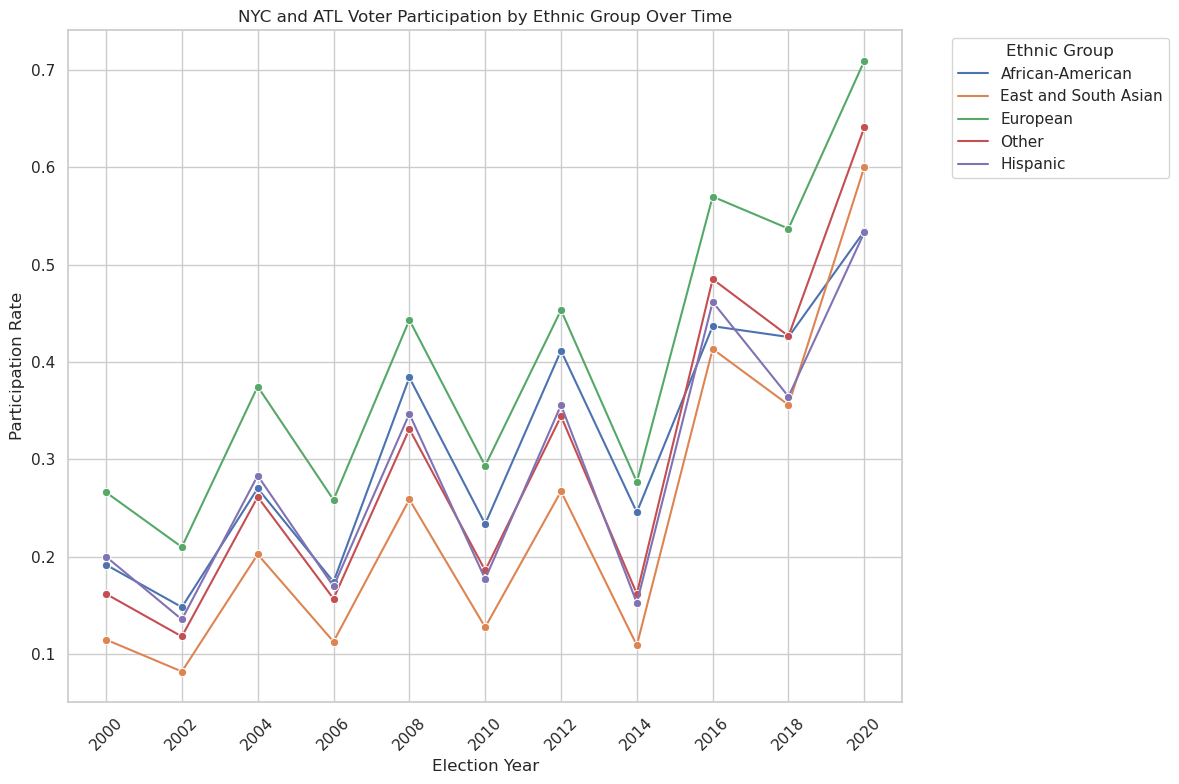

In [22]:
sns.set(style='whitegrid')

# Create a melted version of the dataframe for easier plotting with seaborn
voter_data_melted = voter_df1.melt(id_vars=['Ethnicity'], var_name='Year', value_name='Participation')

# Plot
plt.figure(figsize=(12, 8), facecolor='white')
sns.lineplot(data=voter_data_melted, x='Year', y='Participation', hue='Ethnicity', marker='o')
plt.title('NYC and ATL Voter Participation by Ethnic Group Over Time')
plt.xticks(rotation=45)
plt.ylabel('Participation Rate')
plt.xlabel('Election Year')
plt.legend(title='Ethnic Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

    Through this visualization, we can discern intriguing trends in voter participation starting from 2000. Initially, white voters consistently exhibited higher turnout rates compared to other racial groups, sometimes showcasing a gap of over 10% from the least participatory race. However, over time, this disparity has gradually diminished, owing to extensive voter registration initiatives.

    Moreover, we observe a noteworthy surge in Black voter participation during the years spanning from 2008 to 2014. This peak coincides with the tenure of President Obama, whose representation offered a significant symbol of empowerment and mobilization for the Black community.

    Similarly, there is a noticeable uptick in voter engagement among East and South Asian populations in recent years. This surge aligns with the emergence of Asian candidates in the political landscape, suggesting a potential influence on community mobilization and voter participation.

    Given the distinct trends depicted, the impact of race on voter participation becomes markedly evident.

<a id="align"></a>
## Ethnicity and Political Alignment


In [23]:
import pyspark.sql.functions as F
from pyspark.sql import DataFrame

# Select relevant columns from the DataFrame
atl_party = df_atl.select('EthnicGroups_EthnicGroup1Desc', 'Parties_Description')
atl_party = atl_party.dropna(subset=['EthnicGroups_EthnicGroup1Desc', 'Parties_Description'])

# Calculate total count for each ethnic group
atl_group_totals = atl_party.groupby('EthnicGroups_EthnicGroup1Desc').agg(F.count('*').alias('ethnic total'))

# Join the original DataFrame with the total counts
atl_party_counts = atl_party.groupby('EthnicGroups_EthnicGroup1Desc','Parties_Description').agg(F.count('*').alias('total'))
ethnicity_values = atl_party.select('EthnicGroups_EthnicGroup1Desc').distinct()
party_values = atl_party.select('Parties_Description').distinct()

# Create a DataFrame with all combinations of ethnicity and political party
all_combinations = ethnicity_values.crossJoin(party_values)
atl_party_joined = all_combinations.join(atl_party_counts, 
                                           on=['EthnicGroups_EthnicGroup1Desc', 'Parties_Description'], 
                                           how='left').fillna(0, subset=['total'])
atl_ethnicity_party = atl_party_joined.join(atl_group_totals, on='EthnicGroups_EthnicGroup1Desc', how='inner')
# Calculate count for each combination of ethnicity and party description
#atl_party_dist = atl_party_counts.groupby('EthnicGroups_EthnicGroup1Desc', 'Parties_Description') \
 #                                  .agg((F.count('*') / F.first('total') * 100).alias('Percentage'))
atl_ethnicity_party = atl_ethnicity_party.withColumn('Pct', F.col('total')*100 / F.col('ethnic total')).drop('total', 'ethnic total')
atl_ethnic_party_fin = atl_ethnicity_party.toPandas()
atl_ethnic_party_fin.columns = ['Ethnicity','Party','Percentage']

In [24]:
# Select relevant columns from the DataFrame
nyc_party = df_nyc.select('EthnicGroups_EthnicGroup1Desc', 'Parties_Description')
nyc_party = nyc_party.dropna(subset=['EthnicGroups_EthnicGroup1Desc', 'Parties_Description'])

# Calculate total count for each ethnic group
nyc_group_totals = nyc_party.groupby('EthnicGroups_EthnicGroup1Desc').agg(F.count('*').alias('ethnic total'))

# Join the original DataFrame with the total counts
nyc_party_counts = nyc_party.groupby('EthnicGroups_EthnicGroup1Desc','Parties_Description').agg(F.count('*').alias('total'))
nyc_ethnicity_values = nyc_party.select('EthnicGroups_EthnicGroup1Desc').distinct()
nyc_party_values = nyc_party.select('Parties_Description').distinct()

# Create a DataFrame with all combinations of ethnicity and political party
nyc_all_combinations = nyc_ethnicity_values.crossJoin(nyc_party_values)
nyc_party_joined = nyc_all_combinations.join(nyc_party_counts, 
                                           on=['EthnicGroups_EthnicGroup1Desc', 'Parties_Description'], 
                                           how='left').fillna(0, subset=['total'])
nyc_ethnic_party = nyc_party_joined.join(nyc_group_totals, on='EthnicGroups_EthnicGroup1Desc', how='inner')
# Calculate count for each combination of ethnicity and party description
#atl_party_dist = atl_party_counts.groupby('EthnicGroups_EthnicGroup1Desc', 'Parties_Description') \
 #                                  .agg((F.count('*') / F.first('total') * 100).alias('Percentage'))
nyc_ethnic_party_fin = nyc_ethnic_party.withColumn('Pct', F.col('total')*100 / F.col('ethnic total')).drop('total', 'ethnic total')
nyc_ethnic_party_fin = nyc_ethnic_party_fin.toPandas()
nyc_ethnic_party_fin.columns = ['Ethnicity','Party','Percentage']


<a id="aligntable"></a>
## Visualization of Ethnicty and Alignment

    Referencing these graphs, it appears that the prodominant leaning for most parties if not Non-Partisan would be Democrat, heavily outweighing the Republican viewpoints. This could be primarily due to cities being Democrat or Non-partisan hubs which explains the distribution. Although this is suprising for the points of firearm owners, it also provides insight to the potential non-correlated relations between firearms and political alignment or ethnicity. As these figures contradict previous or historical assumptions on more conservative individuals appreciating guns more, it also provides insight on the validity of our proposed question and continued research.

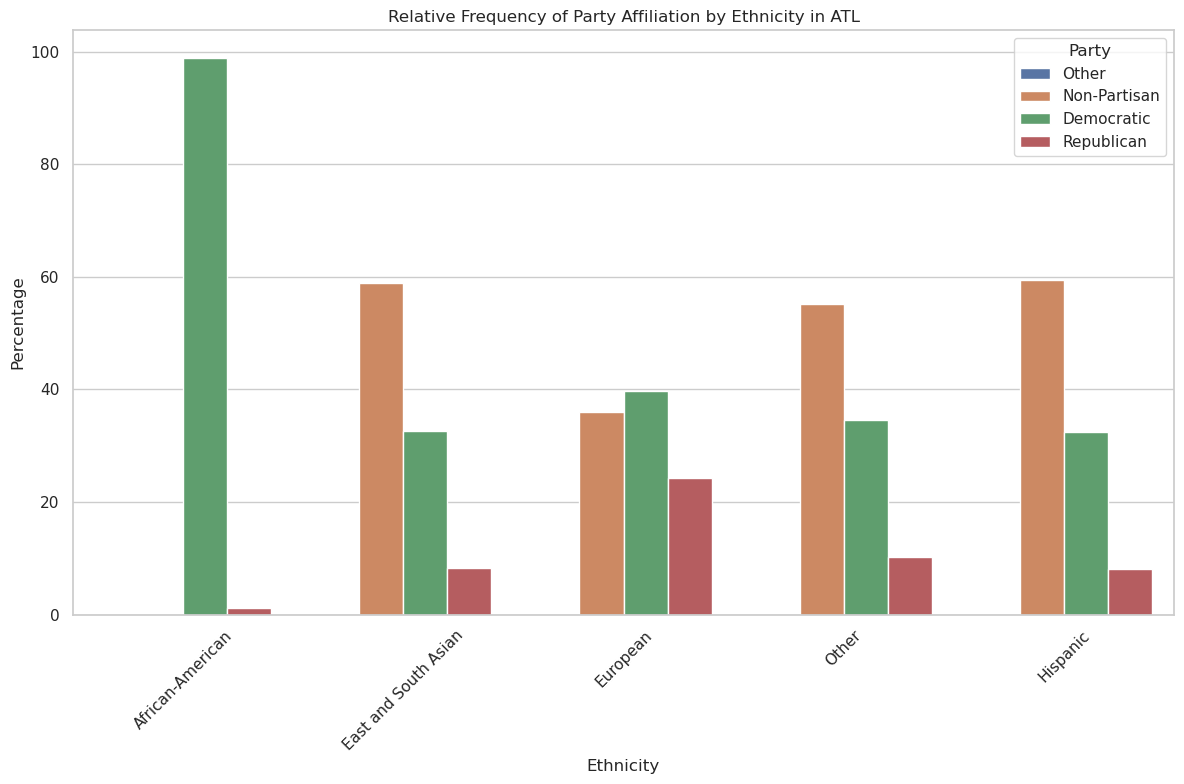

In [25]:
plt.figure(figsize=(12, 8), facecolor='white')

# Creating a grouped bar chart
sns.barplot(x='Ethnicity', y='Percentage', hue='Party', data=atl_ethnic_party_fin)

# Adding plot labels and title
plt.title('Relative Frequency of Party Affiliation by Ethnicity in ATL')
plt.xlabel('Ethnicity')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Party')

# Display the plot
plt.tight_layout()
plt.show()

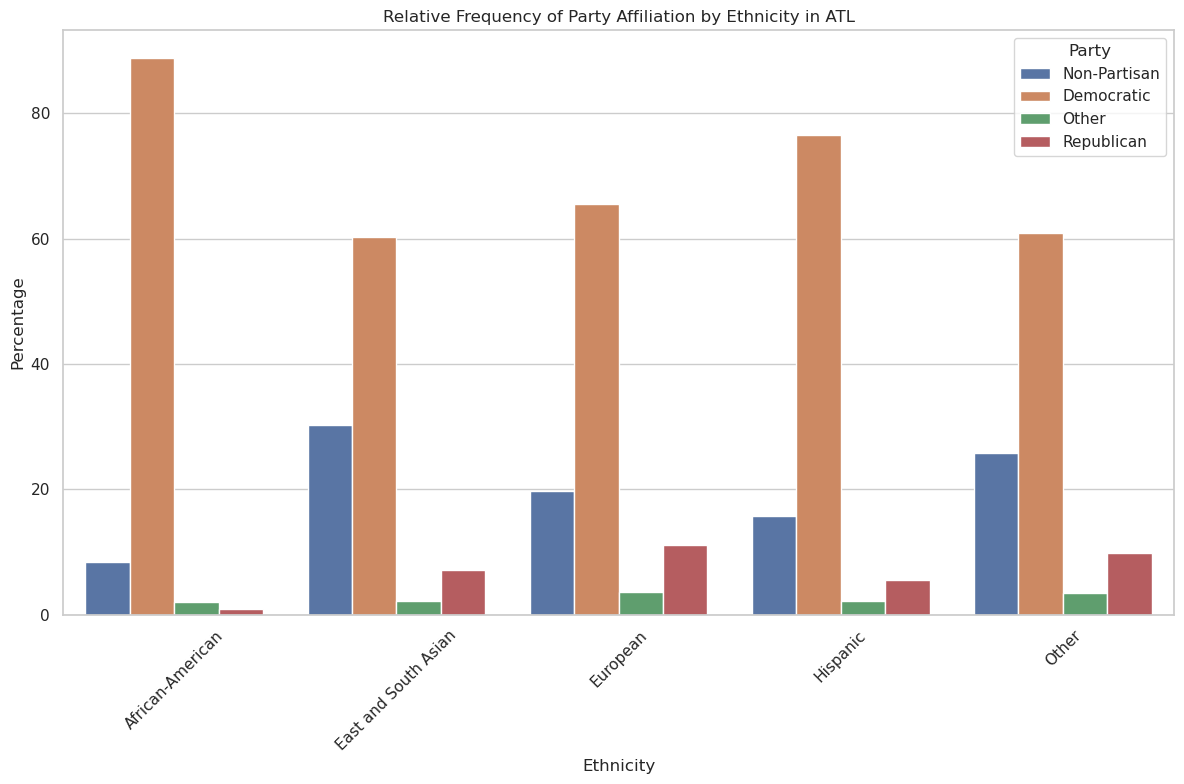

In [26]:
plt.figure(figsize=(12, 8), facecolor='white')

# Creating a grouped bar chart
sns.barplot(x='Ethnicity', y='Percentage', hue='Party', data=nyc_ethnic_party_fin)

# Adding plot labels and title
plt.title('Relative Frequency of Party Affiliation by Ethnicity in ATL')
plt.xlabel('Ethnicity')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Party')

# Display the plot
plt.tight_layout()
plt.show()

    In these figures, it appears in Atlanta that the majority of all ethnicities are Democrat which is suprising for a long time historical 'red' state. Another figure suprise is New York with the majority of other ethnicities aligning Non-Partisan with African American voting prodominately Democrat. Although these figures do shed light on the larger Geo-Political Scale, for the purposes of this project it provides proof of firearm ownership being independent of these two other large factors in the voting block.
    
    Observing the above plot it is clear that there is prodominately Democratic or Non-Partisan leanings for all ethnicities in both cities. Although this graph series provides this insight, it does not necessarily explain the discrepencies between voters in their ethnic blocks and the large increase upon owning a firearm. In our analysis this is instead indicative that firearm ownership is non-correlated with ethnicity or political aligance but instead simply a motivator for individuals to engage in United States politics. To explore this topic and model such assumptions a machine learning and linear regressional model is constructed to express such.

    Below is a machine learning model in which to test a prediction on the likelihood an individual with a firearm is to vote. Along with an accuracry counter to indicate the validity of such. In this portion of the topic Logistic Regression along with Elastic Net. Below is an amalgimation of data filtration, selection, cleaning and finally visualization. 

<a id="ml"></a>
## Machine Learning 

In [10]:
# Filter the DataFrame
df_filtered = df.filter((df["Residence_Addresses_City"] == "Atlanta") | (df["Residence_Addresses_City"] == "New York"))

# Register the DataFrame as a temporary view
df_filtered.createOrReplaceTempView("df_filtered")


In [11]:
research_cols = ["CommercialDataLL_Gun_Owner","CommercialDataLL_Gun_Owner_Concealed_Permit",
                 "EthnicGroups_EthnicGroup1Desc", "General_2018"]

gun_df = df_filtered.select(*research_cols)

In [12]:
gun_df = gun_df.na.fill(value="no")
gun_df.show(3)

+--------------------------+-------------------------------------------+-----------------------------+------------+
|CommercialDataLL_Gun_Owner|CommercialDataLL_Gun_Owner_Concealed_Permit|EthnicGroups_EthnicGroup1Desc|General_2018|
+--------------------------+-------------------------------------------+-----------------------------+------------+
|                        no|                                         no|                     Hispanic|           Y|
|                        no|                                         no|                     European|          no|
|                        no|                                         no|                     European|          no|
+--------------------------+-------------------------------------------+-----------------------------+------------+
only showing top 3 rows



In [13]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder

categorical = ["CommercialDataLL_Gun_Owner", "CommercialDataLL_Gun_Owner_Concealed_Permit", "EthnicGroups_EthnicGroup1Desc",]

stages = [] # stages in Pipeline

for col in categorical:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=col,outputCol=col + "Index", handleInvalid="skip")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()],outputCols=[col + "classVec"])
    # Add stages. These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [14]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="General_2018", outputCol="label", handleInvalid="skip")
stages += [label_stringIdx]

In [15]:
# Transform all features into a vector using VectorAssembler
assemblerInputs = [c + "classVec" for c in categorical] 
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features", handleInvalid='skip')
stages += [assembler]

In [16]:
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(gun_df)
preppedDataDF = pipelineModel.transform(gun_df)

In [17]:
# Keep relevant columns
cols = gun_df.columns
selectedcols = ["label", "features"] + cols
dataset = preppedDataDF.select(selectedcols)

In [18]:
from pyspark.ml.classification import LogisticRegression
# split data into test and train 
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed=42)
# Create initial LogisticRegression model
regression = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
# Train model with Training Data
lr = regression.fit(trainingData)
# Fit model 
predictions = lr.transform(testData)

In [19]:
selected = predictions.select("label", "prediction", "probability", 
                              "CommercialDataLL_Gun_Owner", "EthnicGroups_EthnicGroup1Desc")
selected.show(10)

+-----+----------+--------------------+--------------------------+-----------------------------+
|label|prediction|         probability|CommercialDataLL_Gun_Owner|EthnicGroups_EthnicGroup1Desc|
+-----+----------+--------------------+--------------------------+-----------------------------+
|  0.0|       1.0|[0.32152920080893...|                       Yes|                        Other|
|  0.0|       1.0|[0.32152920080893...|                       Yes|                        Other|
|  0.0|       1.0|[0.32152920080893...|                       Yes|                        Other|
|  0.0|       1.0|[0.32152920080893...|                       Yes|                        Other|
|  0.0|       0.0|[0.58408584644295...|                        no|                        Other|
|  0.0|       0.0|[0.58408584644295...|                        no|                        Other|
|  0.0|       0.0|[0.58408584644295...|                        no|                        Other|
|  0.0|       0.0|[0.584085846

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Evaluate model
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)
evaluator.getMetricName()

'areaUnderROC'

Logistic Regression outputted an area under the ROC curve value of 0.59

In [21]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

# Assuming lr is your LogisticRegression model, trainingData is your training dataset

# Create an instance of LogisticRegression (estimator)
lr = LogisticRegression()

# Create an instance of BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()

# Define a grid of parameters to search over
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) \
    .build()

# Create CrossValidator with LogisticRegression estimator, evaluator, and paramGrid
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)  # Number of folds for cross-validation

# Run cross-validation, and choose the best set of parameters
cvModel = crossval.fit(trainingData)

# Get the best model from cross-validation
bestModel = cvModel.bestModel

# Get the best value of elasticNetParam
bestElasticNetParam = bestModel.getOrDefault("elasticNetParam")
print("Best elasticNetParam:", bestElasticNetParam)

Best elasticNetParam: 0.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.linalg import SparseVector

# Assuming testData is your test dataset and lr_2 is the best LogisticRegression model from cross-validation
# Make predictions using the best model
predicted_probabilities = predictions.select("probability").collect()
actual_labels = predictions.select("label").collect()
feature_values = predictions.select("features").collect()

# Extract probabilities, labels, and feature values from the predictions
probabilities = [float(p[0][1]) for p in predicted_probabilities]
labels = [int(label[0]) for label in actual_labels]

# Convert SparseVector feature values to float
feature_values = [float(features[0].toArray()[0]) for features in feature_values if isinstance(features[0], SparseVector)]

# Sort feature values and corresponding probabilities
sorted_indices = np.argsort(feature_values)
sorted_feature_values = np.array(feature_values)[sorted_indices]
sorted_probabilities = np.array(probabilities)[sorted_indices]

 Attempting to run elastic net regression in order to improve our model, we return the best penatly parameter being equal to 0.0, this means we should return to our original logistic regression model for the data.

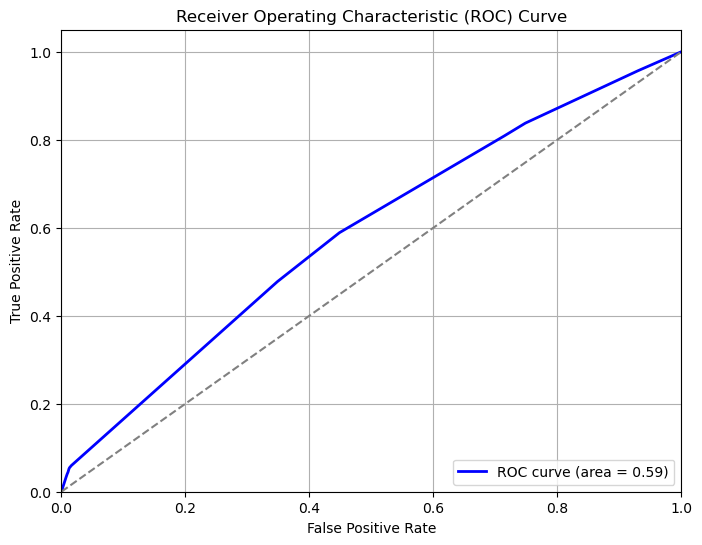

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc

# Assuming predictions is your DataFrame containing label and probability columns
labels = np.array(predictions.select("label").rdd.map(lambda row: row[0]).collect())
probabilities = np.array(predictions.select("probability").rdd.map(lambda row: row[0][1]).collect())

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

    These two explorations display a correlation between firearm ownership and voting turnout as on average firearm owners in all categories are higher. Despite this, there are further explorative topics to analyze such as the racial demographic of these cities that can influence voting. Historically, non-Caucasian individuals are more likely to align themselves with “blue” or social politics more often. In the subsequent sections, we explore the racial demographics of New York and Atlanta to see if these are the causes of such discrepancies. The above machine learning algorithm has displayed our accuracy and finalization of the project subject.


<a id="con"></a>
## Conclusion


    United States Politics are often convoluted with many extraneous factors dictation how individuals will vote and participate in elections. In this project we explored the data relating with Ethnicity, Political Alignment, and Firearm Ownership in the cities of New York and Atlanta. Through this exploration we saw clear trends between gun ownership and voter turn out in all departments regardless of political alignment or ethnicity. Although some assumptions can be made due to population factors or demographic, the implication on firearm ownership influence on individuals has made it possible to accurately assess citizen involvment in election periods. 
    
    Some factors dictation project bias could be the selection of cities that have prodominately democratic leaning but as a project base this is perhaps due to the particular subjects and different cities may lead to different results. However, throughout the United States cities tend to be Democrat leaning as assertained through census figures and election figures. Likewise, the bias following potential ethnic dispersion is also overwritten as Atlanta follows a different ethnic majority but still retains high firearm ownership which dispells potential bias. Across the board through race and political alignment those with guns are roughly ~9% more likely to vote. This is discovered through the various visualizations and graphs dictating such. 
    
    Usage in the grand political scheme is extremely impressive as the United States sports the highest firearms per capita in the world and as a political tool, to enlist the voting power of a population that is more inclined to partipate in elections is essential. Utilities for such can be used through advertisement and propoganda relating to firearms and this information can be utilized in targeting general population demographics and cities regardless of alignment. As explored through the data, Democrats in both cities have a higher firearm ownership then the previously assumed Republican followers. Overall this data and project can assist in percision strikes or political campaigns throughout the United States.